In [1]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/infres/avalenca-22/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
device

device(type='cpu')

In [169]:
import src.CayleyNet as CayleyNet
import src.CORA as CORA
import src.utils as utils

In [170]:
# Reload when files are changed
import importlib
importlib.reload(CayleyNet)
importlib.reload(CORA)
importlib.reload(utils)

<module 'src.utils' from '/home/infres/avalenca-22/CayleyNets/src/utils.py'>

In [171]:
# Import dataset
cora = CORA.CORA()

Parsing files...
Done.


In [172]:
# Print properties of the dataset
dataset = cora
print(dataset.description)
print(f'Number of nodes: {dataset.n}')
print(f'Number of edges: {dataset.n_edges}')
print(f'Number of features per node: {dataset.n_features}')

CORA dataset
Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433


In [173]:
# Extended split of the CORA dataset
train_mask, test_mask, val_mask = utils.split_train_test_val(cora.n, 500, 500) 

In [174]:
# Features and labels as tensors
features = torch.Tensor(1.0*dataset.features).to(device)
labels = torch.Tensor(dataset.labels).long().to(device)
edge_index = dataset.get_edge_index()

# Masks as tensors
train_mask = torch.Tensor(train_mask).bool().to(device)
test_mask = torch.Tensor(test_mask).bool().to(device)
val_mask = torch.Tensor(val_mask).bool().to(device)

In [175]:
# Hyperparameters (Section 4.5)
in_feats = dataset.n_features
n_classes = dataset.n_classes
n_hidden = 16
n_layers = 1 # number of hidden+output layers
r = 5 # Cayley polynomial order 
# obs: we weren't able to identify the value of this last parameter in the paper

In [176]:
model = CayleyNet.CayleyNet(in_feats, n_classes, n_hidden, n_layers, r=5, p_dropout=0.5, normalization = 'sym', sparse=False, seed=0)

In [177]:
print(model)
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[0].parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[1].parameters())}')

CayleyNet(
  (layers): ModuleList(
    (0): CayleyConv(1433, 16, r=5, normalization=sym)
    (1): CayleyConv(16, 7, r=5, normalization=sym)
  )
)
Number of parameters: 23042
Number of parameters: 22929
Number of parameters: 113


In [178]:
# Optimizer
lr = 5e-3
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [179]:
# Train the model
batch_size = 32
epochs = 100

# save loss values for plotting
loss_values = []
val_score = []
train_score = []

verbose = True
for e in range(epochs):
    start = time.time()

    # Compute output
    logp = model(features, edge_index)

    # Compute loss
    loss = F.nll_loss(logp[train_mask], labels[train_mask])
    loss_values.append(loss.item())

    # Perform backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    score = utils.eval_pytorch_geometric_model(model, edge_index, features, labels, train_mask)
    train_score.append(score)

    score = utils.eval_pytorch_geometric_model(model, edge_index, features, labels, val_mask)
    val_score.append(score)

    # Print loss
    end = time.time()
    if verbose:
        print("Epoch {:02d} | Loss {:.3f} | Accuracy (validation) {:.3f} | Elapsed time: {:.2f}s".format(e, loss.item(), score, end - start))

Epoch 00 | Loss 2.201 | Accuracy (validation) 0.098 | Elapsed time: 7.95s
Epoch 01 | Loss 2.028 | Accuracy (validation) 0.122 | Elapsed time: 7.93s
Epoch 02 | Loss 1.947 | Accuracy (validation) 0.142 | Elapsed time: 7.59s
Epoch 03 | Loss 1.886 | Accuracy (validation) 0.154 | Elapsed time: 7.63s
Epoch 04 | Loss 1.836 | Accuracy (validation) 0.180 | Elapsed time: 7.58s
Epoch 05 | Loss 1.791 | Accuracy (validation) 0.204 | Elapsed time: 7.57s
Epoch 06 | Loss 1.746 | Accuracy (validation) 0.226 | Elapsed time: 7.88s
Epoch 07 | Loss 1.700 | Accuracy (validation) 0.250 | Elapsed time: 8.32s
Epoch 08 | Loss 1.652 | Accuracy (validation) 0.268 | Elapsed time: 7.90s
Epoch 09 | Loss 1.601 | Accuracy (validation) 0.294 | Elapsed time: 7.60s
Epoch 10 | Loss 1.548 | Accuracy (validation) 0.314 | Elapsed time: 7.93s
Epoch 11 | Loss 1.494 | Accuracy (validation) 0.316 | Elapsed time: 7.60s
Epoch 12 | Loss 1.439 | Accuracy (validation) 0.318 | Elapsed time: 7.54s
Epoch 13 | Loss 1.384 | Accuracy (vali

In [180]:
test_score = utils.eval_pytorch_geometric_model(model, edge_index, features, labels, test_mask)
print("Test accuracy {:.3f}".format(test_score))

Test accuracy 0.694


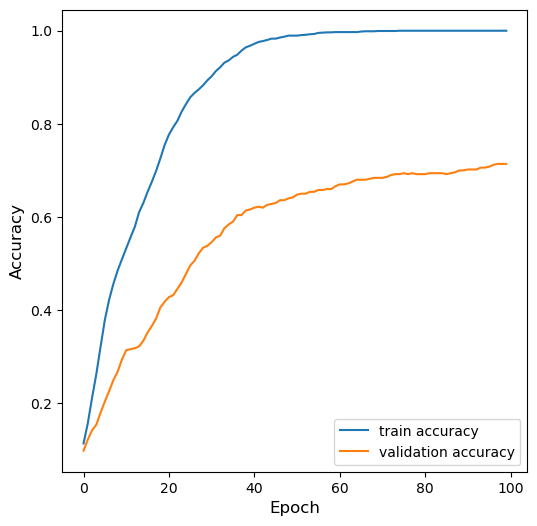

In [181]:
utils.plot_accuracy(train_score, val_score)

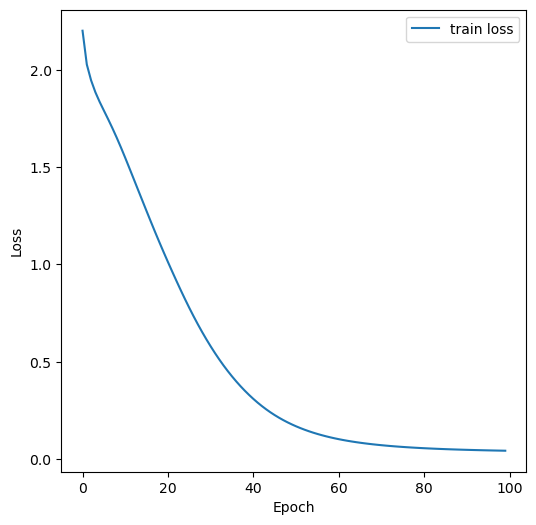

In [182]:
utils.plot_loss(loss_values)